In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import os
from pathlib import Path

<IPython.core.display.Javascript object>

### Crop images

In [10]:
def split_video(video_name):
    save_dir = video_name[:-4]
    vidcap = cv2.VideoCapture(f"data/{video_name}")
    ret, image = vidcap.read()
    count = 1

    if save_dir not in os.listdir("data_frames"):
        os.mkdir(f"data_frames/{save_dir}")

    while ret:
        cv2.imwrite(f"data_frames/{save_dir}/frame{count}.jpg", image)
        ret, image = vidcap.read()
        count += 1

<IPython.core.display.Javascript object>

In [ ]:
video_ext = ["mov", "mp4"]
for f in tqdm(os.listdir("data")):
    if f[-3:].lower() in video_ext:
        split_video(f)

In [20]:
def crop_frames(save_dir, df):
    for i, row in df.iterrows():
        k, id, x, y, w, h = row.values

        if save_dir not in os.listdir("data_crops"):
            os.mkdir(f"data_crops/{save_dir}")

        img = cv2.imread(f"data_frames/{save_dir}/frame{int(k)}.jpg")
        crop = img[int(y) : int(y + h), int(x) : int(x + w)]
        if crop.size != 0:
            cv2.imwrite(f"data_crops/{save_dir}/frame{int(k)}.jpg", crop)

<IPython.core.display.Javascript object>

In [ ]:
for f in tqdm(os.listdir("data")):
    if ".txt" in f:
        df = pd.read_csv(
            f"data/{f}",
            sep="\t",
            header=None,
            names=["k", "ID_i", "x", "y", "width", "height"],
            skiprows=3,
        )
        df.drop
        crop_frames(f[:-4], df)

## Extract features with use of hog descriptor

In [1]:
from feature_descriptors import hog

In [28]:
crops = {}

<IPython.core.display.Javascript object>

In [29]:
from tqdm import tqdm

for f in os.listdir("data_crops/"):
    class_name = "_".join(f.split("_")[:-1])
    crops[class_name] = []
    for cf in tqdm(os.listdir(f"data_crops/{f}")):
        crop = cv2.imread(f"data_crops/{f}/{cf}")
        crops[class_name].append(hog(crop))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:06<00:00, 106.68it/s]


<IPython.core.display.Javascript object>

In [30]:
X_data = [np.array([np.array(c) for c in crops[f]]) for f in crops]
y_data = [i * np.ones((X.shape[0], 1)) for i, X in enumerate(X_data)]

<IPython.core.display.Javascript object>

In [31]:
X = np.vstack(X_data).astype(np.float32)
y = np.vstack(y_data).astype(np.int32)

<IPython.core.display.Javascript object>

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

## Train SVM model 

In [33]:
def train_svm(x_train, y_train, svm_type=cv2.ml.SVM_C_SVC, svm_kernel=cv2.ml.SVM_LINEAR, term_criteria=(cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6), ):
    svm = cv2.ml.SVM_create()
    svm.setType(svm_type)
    svm.setKernel(svm_kernel)
    svm.setTermCriteria(term_criteria)
    svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)
    svm.save('svm.dat')
    return svm


<IPython.core.display.Javascript object>

In [34]:
svm = train_svm(X_train, y_train)

<IPython.core.display.Javascript object>

In [35]:
result = svm.predict(X_test)[1]
mask = result == y_test
correct = np.count_nonzero(mask)
print(correct * 100.0 / result.size)

99.95608256477821


<IPython.core.display.Javascript object>

In [36]:
def predict(
    img,
    feature_descriptor=hog,
    model=svm,
    class_map={i: f for i, f in enumerate(crops.keys())},
):
    features = feature_descriptor(img)[np.newaxis, ...].astype(np.float32)
    pred = model.predict(features)[1][0][0]

    return class_map[pred]

<IPython.core.display.Javascript object>

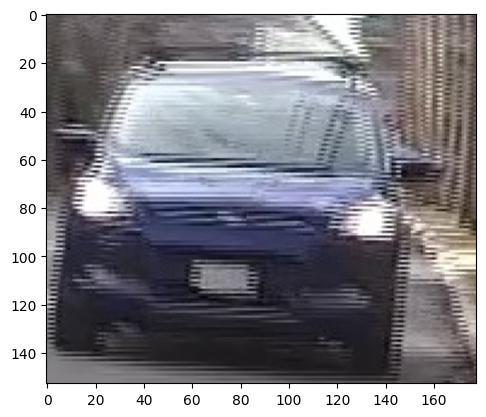

<IPython.core.display.Javascript object>

In [40]:
crop = cv2.imread("data_crops/ford_escape_2011_blue_02/frame101.jpg")
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

In [39]:
predict(crop)

'ford_escape_2011_blue'

<IPython.core.display.Javascript object>